 # M3.2 Recurrent Neural Networks and LSTMs

 [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m3_2_recurrent_neural_network.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m3_2_recurrent_neural_network.ipynb)  



### Learning Objectives
By working through this notebook, you will learn:
- What an RNN is and important aspects of it's architecture
- What different type of RNN setups there are
- How to train each of the RNN variants for a representative task.
    - Including: Sentiment Classification, POS tagging, Sequence inversion
- What an LSTM is, what components it has
- How to train an LSTM for classification and text generation: New Shakespear Bot :)

 ### Setup and Imports

In [ ]:
# ignore warning messages for cleaner output of the website
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  #  Prevent Tensorflow from printing messages 

# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.14.0


 ## 1. Recurrent Neural Networks

 ### 1.1 What is an RNN?

 A Recurrent Neural Network (RNN) is a type of neural network designed to process sequential data. Unlike feedforward networks, RNNs have connections that form cycles, allowing information to persist.

 ### Mathematical Formulation
 At each time step $t$, an RNN computes:
 $$h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$
 $$y_t = W_{hy} h_t + b_y$$
 Where:
 - $x_t$ is the input at time $t$
 - $h_t$ is the hidden state at time $t$
 - $y_t$ is the output at time $t$
 - $W_{hh}, W_{xh}, W_{hy}$ are weight matrices
 - $b_h, b_y$ are bias vectors

 The key property is that $h_t$ depends on $h_{t-1}$, allowing the network to maintain a "memory" of previous inputs.

 ### 1.2 Training RNNs: Backpropagation Through Time
 RNNs are trained using **Backpropagation Through Time (BPTT)**, which unfolds the network across time steps and applies standard backpropagation. The gradient is computed by summing contributions from all time steps.

 **Challenge:** Gradients can vanish or explode when backpropagated through many time steps, making it difficult to learn long-range dependencies. This motivates architectures like LSTM and GRU.

## 2. RNN Application Types

RNNs can be configured in different architectures depending on the task:
1. **Acceptor**: Many-to-one (sequence → single output)
2. **Transducer**: Many-to-many, same length (sequence → sequence)
3. **Encoder-Decoder**: Many-to-many, different length (sequence → sequence)
4. **Bidirectional RNN**: Process sequence in both directions

 ### 2.1 Acceptor: Sequence Classification

<!-- ![acceptor_fig](./figures/rnn_figs/acceptor.png) -->

<p align="center">
    <img src="https://raw.githubusercontent.com/cltl/ml4nlp_tutorial_notebooks/refs/heads/main/figures/rnn_figs/acceptor.png" alt="acceptor_fig" style="max-width:40%;">
</p>

- **Use case:** Sentiment analysis, topic classification
- **Architecture:** Process entire sequence and output a single prediction
- **Example:** Binary sentiment classification on movie reviews

In [2]:
# Load IMDb dataset for sentiment classification
print("Loading IMDb dataset...")
dataset = load_dataset("imdb", split="train")  # Subset for faster training
# shuffle and select a smaller subset for quick demonstration
# dataset = dataset.shuffle(seed=42).select(range(5000))
dataset = dataset.shuffle(seed=42)

texts = dataset["text"]
labels = dataset["label"]

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Loading IMDb dataset...
Training samples: 20000
Validation samples: 5000


 #### Text Preprocessing

In [9]:
# Tokenization
max_words = 3000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding="post", truncating="post")

y_train = np.array(y_train)
y_val = np.array(y_val)

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequence shape: {X_train_pad.shape}")


Vocabulary size: 79991
Padded sequence shape: (20000, 100)


#### Build RNN Acceptor Model
- The key RNN part of the model pipeline is `layers.SimpleRNN()`. Note that for the acceptor model we only care about the final output so we set `return_sequences=False`.
- Similar to the previous notebooks, we first take an embedding layer, which creates word embeddings for each word in our dataset. As usual the last layer is a dense linear layer to create a prediction over the number of output classes.  

In [10]:
# RNN model for binary classification
model_acceptor = keras.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    layers.SimpleRNN(64, return_sequences=False),  # Return only final hidden state
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model_acceptor.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_acceptor.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           192000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 200321 (782.50 KB)
Trainable params: 200321 (782.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the Acceptor

In [11]:
history_acceptor = model_acceptor.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    verbose=1
)

Epoch 1/5
625/625 [==============================] - 13s 20ms/step - loss: 0.7089 - accuracy: 0.5089 - val_loss: 0.6948 - val_accuracy: 0.5040
Epoch 2/5
625/625 [==============================] - 12s 19ms/step - loss: 0.7057 - accuracy: 0.5064 - val_loss: 0.6908 - val_accuracy: 0.5268
Epoch 3/5
625/625 [==============================] - 12s 19ms/step - loss: 0.6896 - accuracy: 0.5393 - val_loss: 0.6750 - val_accuracy: 0.5880
Epoch 4/5
625/625 [==============================] - 12s 19ms/step - loss: 0.6698 - accuracy: 0.5867 - val_loss: 0.6751 - val_accuracy: 0.5760
Epoch 5/5
625/625 [==============================] - 12s 19ms/step - loss: 0.6160 - accuracy: 0.6757 - val_loss: 0.5843 - val_accuracy: 0.7150


**Analysis:**
- We see that the model performs the task with around 70% accuracy in this toy setup, which shows us that the model does learn to perform better on the task but it's still much less thatn the range of ~80% we have seen using the other simpler model such as Naive Bayes Classification. The main reason is that the hyperparameters we have set are likely not optimal for this setup.
For better performance we should apply hyper parameter optimization of:
- `max_words`  : how many words should our vocabulary have? To few words and we lose information, too many words and it becomes very difficult to learn all of them (remember zipfs law!), and we also risk overfitting
- `max_len` : How many words long should we allow the input reviews to be? Currently we say max 100 words which is not that long.
- `hidden_dim` of the RNN: What should the hidden dimension of the RNN be? If it is too small, we can't learn much, if it is too large, it becomes much harder to learn.
 

#### Test Prediction

In [13]:
def predict_sentiment(text, model, tokenizer, max_len):
    """Predict sentiment of a text."""
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")
    pred = model.predict(padded, verbose=0)[0][0]
    sentiment = "Positive" if pred > 0.5 else "Negative"
    return sentiment, pred

# Test examples
test_examples = [
    "This movie was absolutely wonderful! I loved it.",
    "Terrible film. Complete waste of time.",
    "It was okay, nothing special."
]

print("\nSentiment Predictions:")
print("-" * 60)
for text in test_examples:
    sentiment, score = predict_sentiment(text, model_acceptor, tokenizer, max_len)
    print(f"Text: {text[:50]}...")
    print(f"Prediction: {sentiment} (score: {score:.4f})\n")



Sentiment Predictions:
------------------------------------------------------------
Text: This movie was absolutely wonderful! I loved it....
Prediction: Positive (score: 0.7540)

Text: Terrible film. Complete waste of time....
Prediction: Negative (score: 0.2836)

Text: It was okay, nothing special....
Prediction: Negative (score: 0.2935)



### 2.2 Transducer: Sequence Labeling

<p align="center">
    <img src="https://raw.githubusercontent.com/cltl/ml4nlp_tutorial_notebooks/refs/heads/main/figures/rnn_figs/transducer_rrn.png" alt="transducor_fig" style="max-width:40%;">
</p>

- **Use case:** Part-of-speech tagging, Named Entity Recognition
- **Architecture:** Output a label for each input token (same length)
- **Example:** Part-of-Speech (POS) Tagging

Package for installation: `pip install conllu` 


 <!-- ```bash
 pip install conllu
 ``` -->

In [53]:
# Load Universal Dependencies POS tagging dataset
print("Loading Universal Dependencies POS dataset...")
pos_dataset = load_dataset("universal_dependencies", "en_ewt", split="train")
print(f" Total samples in POS dataset: {len(pos_dataset)}")

# shuffle and get the first 5000 samples for quick demonstration
pos_dataset = pos_dataset.shuffle(seed=42)
# .select(range(5000))


# Extract tokens and POS tags
tokens_list = pos_dataset["tokens"]
pos_tags_list = pos_dataset["upos"]

# Universal POS tags
pos_labels = ["ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", 
              "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"]
# Create tag to index mapping
tag2idx = {tag: idx + 1 for idx, tag in enumerate(pos_labels)}  # Reserve 0 for padding
tag2idx["<PAD>"] = 0
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

num_tags = len(tag2idx)

print(f"Number of sequences: {len(tokens_list)}")
print(f"POS tags: {pos_labels}")
print(f"Total tags (including padding): {num_tags}")

Loading Universal Dependencies POS dataset...
 Total samples in POS dataset: 12543
Number of sequences: 12543
POS tags: ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Total tags (including padding): 18


#### Prepare POS Tagging Data

In [54]:
from datasets import load_dataset

# Load dataset
print("Loading Universal Dependencies POS dataset...")
pos_dataset = load_dataset("universal_dependencies", "en_ewt", split="train[:2000]")

# Get the actual label names from the dataset's features
pos_labels = pos_dataset.features["upos"].feature.names
print(f"Actual POS labels from dataset: {pos_labels}")

# Create tag to index mapping (dataset already uses 0-indexed labels)
tag2idx = {tag: idx for idx, tag in enumerate(pos_labels)}
tag2idx["<PAD>"] = len(pos_labels)  # Add padding at the end
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

# Extract tokens and POS tags
tokens_list = pos_dataset["tokens"]
pos_tags_list = pos_dataset["upos"]

# If you want string labels instead of indices:
pos_tags_strings = [[pos_labels[idx] for idx in seq] for seq in pos_tags_list]

print(f"Number of sequences: {len(tokens_list)}")
print(f"Total tags (including padding): {len(tag2idx)}")
print(f"\nExample:")
print(f"Tokens: {tokens_list[0]}")
print(f"POS indices: {pos_tags_list[0]}")
print(f"POS labels: {pos_tags_strings[0]}")

num_tags = len(pos_labels) + 2
print(f"Total tags (including padding): {num_tags}")

Loading Universal Dependencies POS dataset...
Actual POS labels from dataset: ['NOUN', 'PUNCT', 'ADP', 'NUM', 'SYM', 'SCONJ', 'ADJ', 'PART', 'DET', 'CCONJ', 'PROPN', 'PRON', 'X', '_', 'ADV', 'INTJ', 'VERB', 'AUX']
Number of sequences: 2000
Total tags (including padding): 19

Example:
Tokens: ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']
POS indices: [10, 1, 10, 1, 6, 0, 16, 10, 10, 10, 1, 10, 1, 8, 0, 2, 8, 0, 2, 8, 0, 2, 10, 1, 2, 8, 6, 0, 1]
POS labels: ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']
Total tags (including padding): 20


In [55]:
# Build word vocabulary
all_words = [word for tokens in tokens_list for word in tokens]
word_vocab = sorted(set(all_words))
word2idx = {word: idx + 2 for idx, word in enumerate(word_vocab)}  # Reserve 0 for padding, 1 for UNK
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

# Convert tokens and tags to indices
max_seq_len = 50
X_pos = []
y_pos = []

for tokens, tags in zip(tokens_list, pos_tags_list):
    # Convert tokens to indices
    token_ids = [word2idx.get(token, 1) for token in tokens]
   
    # Tags are already numeric indices from the dataset - use them directly
    # Add 1 to all tag indices to reserve 0 for padding
    tag_ids = [tag + 1 for tag in tags]
   
    # Pad or truncate
    if len(token_ids) < max_seq_len:
        token_ids += [0] * (max_seq_len - len(token_ids))
        tag_ids += [0] * (max_seq_len - len(tag_ids))
    else:
        token_ids = token_ids[:max_seq_len]
        tag_ids = tag_ids[:max_seq_len]
   
    X_pos.append(token_ids)
    y_pos.append(tag_ids)

X_pos = np.array(X_pos)
y_pos = np.array(y_pos)

# Split data
X_pos_train, X_pos_val, y_pos_train, y_pos_val = train_test_split(
    X_pos, y_pos, test_size=0.2, random_state=42
)

print(f"Vocabulary size: {len(word2idx)}")
print(f"Training sequences: {X_pos_train.shape}")
print(f"Example sentence: {tokens_list[0][:10]}")
print(f"Example POS tags (original indices): {pos_tags_list[0][:10]}")
print(f"Example POS tags (shifted +1 for padding): {[tag + 1 for tag in pos_tags_list[0][:10]]}")

Vocabulary size: 7088
Training sequences: (1600, 50)
Example sentence: ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al']
Example POS tags (original indices): [10, 1, 10, 1, 6, 0, 16, 10, 10, 10]
Example POS tags (shifted +1 for padding): [11, 2, 11, 2, 7, 1, 17, 11, 11, 11]


#### Build RNN Transducer Model for POS Tagging
- The setup is very similar to that of the Acceptor but this time we do want the embedding outputs for each item in the sequence so we have to set `return_sequences=True` for the class `layers.SimpleRNN()`

In [58]:
# RNN model for POS tagging
model_transducer = keras.Sequential([
    layers.Embedding(input_dim=len(word2idx), output_dim=64, mask_zero=True),
    layers.SimpleRNN(64, return_sequences=True),
    layers.Dense(num_tags, activation="softmax")  # Now has correct number of outputs
])
model_transducer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model_transducer.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          453632    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 64)          8256      
                                                                 
 dense_9 (Dense)             (None, None, 20)          1300      
                                                                 
Total params: 463188 (1.77 MB)
Trainable params: 463188 (1.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train the Transducer

In [59]:
history_transducer = model_transducer.fit(
    X_pos_train, y_pos_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_pos_val, y_pos_val),
    verbose=1
)

Epoch 1/10
50/50 [==============================] - 2s 24ms/step - loss: 2.6031 - accuracy: 0.2048 - val_loss: 2.3872 - val_accuracy: 0.2780
Epoch 2/10
50/50 [==============================] - 1s 18ms/step - loss: 2.0481 - accuracy: 0.4512 - val_loss: 1.6971 - val_accuracy: 0.5858
Epoch 3/10
50/50 [==============================] - 1s 17ms/step - loss: 1.3029 - accuracy: 0.6893 - val_loss: 1.0836 - val_accuracy: 0.7202
Epoch 4/10
50/50 [==============================] - 1s 17ms/step - loss: 0.8069 - accuracy: 0.8103 - val_loss: 0.7522 - val_accuracy: 0.8124
Epoch 5/10
50/50 [==============================] - 1s 19ms/step - loss: 0.5141 - accuracy: 0.8897 - val_loss: 0.5728 - val_accuracy: 0.8478
Epoch 6/10
50/50 [==============================] - 1s 17ms/step - loss: 0.3407 - accuracy: 0.9274 - val_loss: 0.4775 - val_accuracy: 0.8653
Epoch 7/10
50/50 [==============================] - 1s 18ms/step - loss: 0.2444 - accuracy: 0.9454 - val_loss: 0.4297 - val_accuracy: 0.8785
Epoch 8/10
50

In [62]:
# Update idx2tag to match the shifted indices used in training
# 0 = padding, 1-17 = actual POS tags
idx2tag_shifted = {0: "<PAD>"}
for idx, label in enumerate(pos_labels):
    idx2tag_shifted[idx + 1] = label  # Shift by +1 to match training data

# Example prediction
sample_idx = 0
sample_tokens = tokens_list[sample_idx][:10]  # First 10 tokens
sample_input = X_pos[sample_idx:sample_idx+1]
predictions = model_transducer.predict(sample_input, verbose=0)
predicted_tags = np.argmax(predictions[0], axis=-1)

print("POS Tagging Example:")
print("-" * 60)
for token, pred_idx, true_idx in zip(sample_tokens,
                                      predicted_tags[:len(sample_tokens)],
                                      pos_tags_list[sample_idx][:len(sample_tokens)]):
    # pred_idx is shifted (0-17), so use idx2tag_shifted
    pred_tag = idx2tag_shifted.get(pred_idx, "UNK")
    
    # true_idx is NOT shifted (0-16), so we need to get the label directly
    true_tag = pos_labels[true_idx] if true_idx < len(pos_labels) else "UNK"
    
    print(f"{token:15s} | Predicted: {pred_tag:8s} | True: {true_tag:8s}")

POS Tagging Example:
------------------------------------------------------------
Al              | Predicted: PROPN    | True: PROPN   
-               | Predicted: PUNCT    | True: PUNCT   
Zaman           | Predicted: PROPN    | True: PROPN   
:               | Predicted: PUNCT    | True: PUNCT   
American        | Predicted: ADJ      | True: ADJ     
forces          | Predicted: NOUN     | True: NOUN    
killed          | Predicted: VERB     | True: VERB    
Shaikh          | Predicted: PROPN    | True: PROPN   
Abdullah        | Predicted: PROPN    | True: PROPN   
al              | Predicted: PROPN    | True: PROPN   


### 2.3 Encoder-Decoder: Sequence-to-Sequence
<p align="center" >
    <img src="https://raw.githubusercontent.com/cltl/ml4nlp_tutorial_notebooks/refs/heads/main/figures/rnn_figs/seq2seq_rnn.svg" alt="seq2seq_fig" style="max-width:40%; background-color: white;">
</p>

- **Use case:** Machine translation, text summarization
- **Architecture:** Encoder processes input sequence into a context vector, decoder generates output sequence
- **Example:** Simple character-level sequence transformation


#### Prepare Sequence-to-Sequence Data



 For demonstration, we'll create a simple task: reverse sequences

In [ ]:
# Generate toy dataset: input sequence → reversed sequence
def generate_seq2seq_data(num_samples=1000, seq_length=10, vocab_size=20):
    """Generate random sequences and their reversals."""
    X = np.random.randint(1, vocab_size, size=(num_samples, seq_length))
    y = np.flip(X, axis=1)
    return X, y

vocab_size_s2s = 20
seq_len_s2s = 10

X_s2s, y_s2s = generate_seq2seq_data(num_samples=2000, seq_length=seq_len_s2s, vocab_size=vocab_size_s2s)

# Split data
X_s2s_train, X_s2s_val, y_s2s_train, y_s2s_val = train_test_split(
    X_s2s, y_s2s, test_size=0.2, random_state=42
)

print(f"Training samples: {X_s2s_train.shape}")
print(f"Example input: {X_s2s_train[0]}")
print(f"Example output: {y_s2s_train[0]}")


Training samples: (1600, 10)
Example input: [10 15  6 15  7  5  4 18  3 17]
Example output: [17  3 18  4  5  7 15  6 15 10]


#### Build Encoder-Decoder Model
- For the encoder-decoder model we create two different RNN implementations first and combine them using the line `keras.Model([first_model, second_model])`

In [ ]:
# Encoder
encoder_inputs = layers.Input(shape=(seq_len_s2s,))
encoder_embedding = layers.Embedding(vocab_size_s2s, 32)(encoder_inputs)
encoder_rnn = layers.SimpleRNN(64, return_state=True)
encoder_outputs, encoder_state = encoder_rnn(encoder_embedding)

# Decoder
decoder_inputs = layers.Input(shape=(seq_len_s2s,))
decoder_embedding = layers.Embedding(vocab_size_s2s, 32)(decoder_inputs)
decoder_rnn = layers.SimpleRNN(64, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_rnn(decoder_embedding, initial_state=encoder_state)
decoder_dense = layers.Dense(vocab_size_s2s, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model_seq2seq = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_seq2seq.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_seq2seq.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 10, 32)               640       ['input_1[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 10, 32)               640       ['input_2[0][0]']             
                                                                                              

#### Train Encoder-Decoder

In [ ]:
# Prepare decoder inputs (shifted target sequences)
decoder_input_train = np.zeros_like(y_s2s_train)
decoder_input_train[:, 1:] = y_s2s_train[:, :-1]

decoder_input_val = np.zeros_like(y_s2s_val)
decoder_input_val[:, 1:] = y_s2s_val[:, :-1]

# Expand dimensions for sparse categorical crossentropy
y_s2s_train_exp = np.expand_dims(y_s2s_train, -1)
y_s2s_val_exp = np.expand_dims(y_s2s_val, -1)

history_seq2seq = model_seq2seq.fit(
    [X_s2s_train, decoder_input_train], y_s2s_train_exp,
    epochs=10,
    batch_size=32,
    validation_data=([X_s2s_val, decoder_input_val], y_s2s_val_exp),
    verbose=1
)


Epoch 1/10
50/50 [==============================] - 1s 10ms/step - loss: 2.8781 - accuracy: 0.1124 - val_loss: 2.6656 - val_accuracy: 0.1822
Epoch 2/10
50/50 [==============================] - 0s 6ms/step - loss: 2.4441 - accuracy: 0.2573 - val_loss: 2.3014 - val_accuracy: 0.2767
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 2.1069 - accuracy: 0.3547 - val_loss: 1.9919 - val_accuracy: 0.3767
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 1.7836 - accuracy: 0.4588 - val_loss: 1.6611 - val_accuracy: 0.5005
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 1.4380 - accuracy: 0.5926 - val_loss: 1.3267 - val_accuracy: 0.6118
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 1.1474 - accuracy: 0.7036 - val_loss: 1.0778 - val_accuracy: 0.7070
Epoch 7/10
50/50 [==============================] - 0s 6ms/step - loss: 0.9416 - accuracy: 0.7751 - val_loss: 0.9002 - val_accuracy: 0.7745
Epoch 8/10
50/50 [=

### 2.4 Bidirectional RNN
<p align="center" >
    <img src="https://raw.githubusercontent.com/cltl/ml4nlp_tutorial_notebooks/refs/heads/main/figures/rnn_figs/bi_rnn.png" alt="bi_rnn_fig" style="max-width:40%; background-color: white;">
</p>


- **Use case:** Tasks where full sequence context improves performance
- **Architecture:** Two RNNs process the sequence in opposite directions
- **Advantage:** Access to both past and future context at each position
- **Example:** Sentiment classification with bidirectional RNN

To construct the model we can use the build in package from keras, and just use function `layers.Bidirectional()` and wrap it around the `SimpleRNN()`.

In [ ]:
# Build Bidirectional RNN model
model_birnn = keras.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences=False)),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model_birnn.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_birnn.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               16512     
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656641 (2.50 MB)
Trainable params: 656641 (2.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train Bidirectional RNN

In [ ]:
history_birnn = model_birnn.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    verbose=1
)


Epoch 1/5
125/125 [==============================] - 5s 37ms/step - loss: 0.7046 - accuracy: 0.5013 - val_loss: 0.6997 - val_accuracy: 0.4940
Epoch 2/5
125/125 [==============================] - 4s 35ms/step - loss: 0.6427 - accuracy: 0.6357 - val_loss: 0.6959 - val_accuracy: 0.5350
Epoch 3/5
125/125 [==============================] - 4s 35ms/step - loss: 0.5733 - accuracy: 0.7035 - val_loss: 0.6901 - val_accuracy: 0.5620
Epoch 4/5
125/125 [==============================] - 4s 36ms/step - loss: 0.3091 - accuracy: 0.8907 - val_loss: 0.8787 - val_accuracy: 0.5580
Epoch 5/5
125/125 [==============================] - 4s 34ms/step - loss: 0.1710 - accuracy: 0.9433 - val_loss: 0.9092 - val_accuracy: 0.5720


In [ ]:
# Compare with unidirectional RNN
val_loss_birnn, val_acc_birnn = model_birnn.evaluate(X_val_pad, y_val, verbose=0)
val_loss_rnn, val_acc_rnn = model_acceptor.evaluate(X_val_pad, y_val, verbose=0)

print(f"\nUnidirectional RNN Validation Accuracy: {val_acc_rnn:.4f}")
print(f"Bidirectional RNN Validation Accuracy: {val_acc_birnn:.4f}")
print(f"Improvement: {(val_acc_birnn - val_acc_rnn)*100:.2f}%")



Unidirectional RNN Validation Accuracy: 0.4890
Bidirectional RNN Validation Accuracy: 0.5720
Improvement: 8.30%


## 3. Long Short-Term Memory (LSTM)

### 3.1 Why LSTM?
Standard RNNs suffer from the **vanishing gradient problem**, making it difficult to learn long-range dependencies. LSTMs address this through a gating mechanism that controls information flow.

### 3.2 LSTM Architecture


<p align="center" >
    <img src="https://raw.githubusercontent.com/cltl/ml4nlp_tutorial_notebooks/refs/heads/main/figures/rnn_figs/LSTM.webp" alt="LSTM_fig" style="max-width:40%; background-color: white;">
</p>

 An LSTM unit consists of:
 1. **Cell state** ($C_t$): Long-term memory
 2. **Hidden state** ($h_t$): Short-term memory
 3. **Three gates**:
    - **Forget gate** ($f_t$): What to forget from cell state
    - **Input gate** ($i_t$): What new information to store
    - **Output gate** ($o_t$): What to output

 #### Mathematical Formulation
 $$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
 $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
 $$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$
 $$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$
 $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
 $$h_t = o_t \odot \tanh(C_t)$$
 Where:
 - $\sigma$ is the sigmoid function
 - $\odot$ denotes element-wise multiplication
 - $[h_{t-1}, x_t]$ is concatenation of hidden state and input

### 3.3 Application 1: Text Generation with LSTM
-  **Task:** Generate text character-by-character
-  **Training:** Predict the next character given previous characters
 - **Dataset:** Tiny Shakespeare - 40,000 lines of Shakespeare from various plays, url: https://huggingface.co/datasets/karpathy/tiny_shakespeare

 This dataset was featured in Andrej Karpathy's influential blog post ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) where he demonstrated the power of character-level language modeling.

In [ ]:
# Load Tiny Shakespeare dataset
print("Loading Tiny Shakespeare dataset...")
shakespeare_dataset = load_dataset("tiny_shakespeare")
# print(f"Dataset splits: {shakespeare_dataset.keys()}, ")

# use_perc = 0.1
# shakespeare_dataset = shakespeare_dataset.shuffle(seed=42).select(range(int(len(shakespeare_dataset['train']) * use_perc)))

# Get the text
text = shakespeare_dataset["train"][0]["text"]

print(f"Total text length: {len(text):,} characters")
print(f"\nFirst 500 characters:")
print("-" * 70)
print(text[:500])


Loading Tiny Shakespeare dataset...
Total text length: 1,003,854 characters

First 500 characters:
----------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


#### Prepare Character-Level Data

In [ ]:
# Prepare character-level data
chars = sorted(set(text))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

vocab_size_char = len(chars)
print(f"\nVocabulary size: {vocab_size_char} unique characters")
print(f"Characters: {repr(''.join(chars))}")



Vocabulary size: 65 unique characters
Characters: "\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


#### Create Training Sequences

In [ ]:
# Create sequences for training
seq_length = 10  # Length of input sequences
step = 3  # Step between sequences (smaller step = more training data)

sequences = []
next_chars = []

print(f"Creating sequences with length {seq_length}...")

for i in range(0, len(text) - seq_length, step):
    sequences.append([char_to_idx[ch] for ch in text[i:i + seq_length]])
    next_chars.append(char_to_idx[text[i + seq_length]])

X_gen = np.array(sequences)
y_gen = np.array(next_chars)

print(f"Number of training sequences: {len(sequences):,}")
print(f"Input shape: {X_gen.shape}")
print(f"Target shape: {y_gen.shape}")

# Show an example sequence
example_idx = 0
print(f"\nExample sequence {example_idx}:")
print("Input text:", repr(text[example_idx:example_idx + seq_length]))
print("Target char:", repr(text[example_idx + seq_length]))


Creating sequences with length 10...
Number of training sequences: 334,615
Input shape: (334615, 10)
Target shape: (334615,)

Example sequence 0:
Input text: 'First Citi'
Target char: 'z'


#### Build Character-Level LSTM

In [ ]:
model_char_lstm = keras.Sequential([
    layers.Embedding(vocab_size_char, 32, input_length=seq_length),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    layers.Dropout(0.2),
    layers.Dense(vocab_size_char, activation="softmax")
])

model_char_lstm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_char_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 32)            2080      
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           82432     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 65)                8385      
                                                                 
Total params: 224481 (876.88 KB)
Trainable params: 224481 (876.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train Character LSTM
 Note: Training on the full Shakespeare dataset will take some time.

 For a quicker demo, you can reduce the number of epochs or use a smaller subset of the data.

In [ ]:
history_char = model_char_lstm.fit(
    X_gen, y_gen,
    epochs=5,  # Can be increased for better results
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
2353/2353 [==============================] - 50s 21ms/step - loss: 2.0015 - accuracy: 0.4193 - val_loss: 1.9157 - val_accuracy: 0.4324
Epoch 2/5
2353/2353 [==============================] - 49s 21ms/step - loss: 1.8241 - accuracy: 0.4646 - val_loss: 1.8019 - val_accuracy: 0.4658
Epoch 3/5
2353/2353 [==============================] - 49s 21ms/step - loss: 1.7242 - accuracy: 0.4900 - val_loss: 1.7367 - val_accuracy: 0.4825
Epoch 4/5
2353/2353 [==============================] - 49s 21ms/step - loss: 1.6586 - accuracy: 0.5069 - val_loss: 1.6988 - val_accuracy: 0.4952
Epoch 5/5
2353/2353 [==============================] - 49s 21ms/step - loss: 1.6098 - accuracy: 0.5181 - val_loss: 1.6660 - val_accuracy: 0.5033


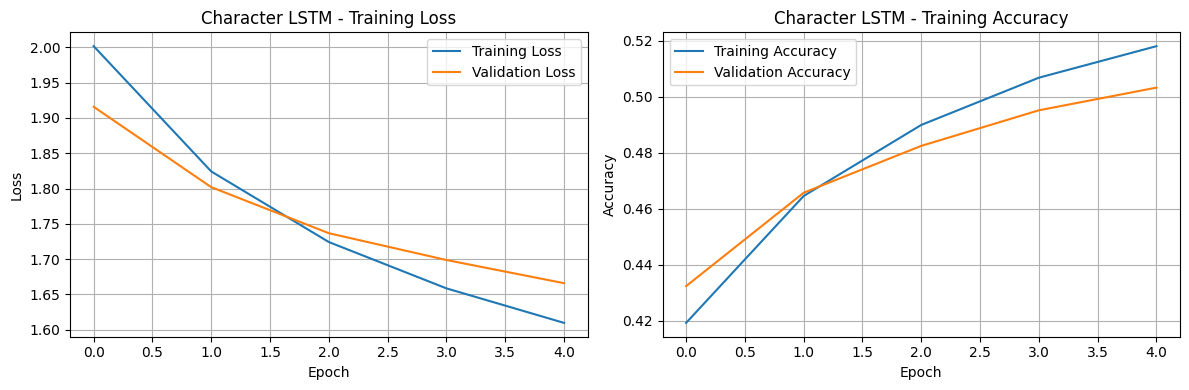

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_char.history["loss"], label="Training Loss")
plt.plot(history_char.history["val_loss"], label="Validation Loss")
plt.title("Character LSTM - Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_char.history["accuracy"], label="Training Accuracy")
plt.plot(history_char.history["val_accuracy"], label="Validation Accuracy")
plt.title("Character LSTM - Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Generate Shakespeare-Style Text

In [ ]:
def generate_text(model, start_string, length=200, temperature=1.0):
    """
    Generate text using trained LSTM.
    
    Args:
        model: Trained Keras model
        start_string: Initial string to start generation
        length: Number of characters to generate
        temperature: Controls randomness (lower = more conservative, higher = more random)
    """
    generated = start_string
    input_seq = [char_to_idx.get(ch, 0) for ch in start_string]
    
    for _ in range(length):
        # Pad sequence to correct length
        if len(input_seq) < seq_length:
            padded = [0] * (seq_length - len(input_seq)) + input_seq
        else:
            padded = input_seq[-seq_length:]
        
        # Predict next character
        x = np.array([padded])
        predictions = model.predict(x, verbose=0)[0]
        
        # Apply temperature for diversity
        predictions = np.log(predictions + 1e-10) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))
        
        # Sample from distribution
        next_idx = np.random.choice(len(predictions), p=predictions)
        next_char = idx_to_char[next_idx]
        
        generated += next_char
        input_seq.append(next_idx)
    
    return generated


In [ ]:
# Generate text samples with different settings
print("Generated Shakespeare-style text:\n")
print("=" * 70)

start_strings = ["ROMEO:", "To be or not to be", "The "]
temperatures = [0.5, 1.0, 1.5]

for start in start_strings:
    print(f"\n\nStarting with: '{start}'")
    print("-" * 70)
    for temp in temperatures:
        print(f"\nTemperature: {temp}")
        generated = generate_text(model_char_lstm, start, length=200, temperature=temp)
        print(generated)
        print()


Generated Shakespeare-style text:



Starting with: 'ROMEO:'
----------------------------------------------------------------------

Temperature: 0.5
ROMEO:
The sunder to the crown,
On that my lord,
And not the hay send,
And another country becare a send,
The sand he good king some to the hand in what we have a vorse the behald me not the encount and man


Temperature: 1.0
ROMEO:
Seme thy courtion metudes our fruth.

RAMELES:
All here I ap: twere out in fall eacured will-wim, by redbed?

WARWICK:
We meads as, the heart fomel-lores! thoud speed; God thou Lary, on anoved;
What 


Temperature: 1.5
ROMEO:
O, Evuy-On Chirge you so!
Nod; eyes by the
messuenous.

AllaR:
Shall boin Piliesar ig.n
In! 'bh gade oot a ot warns; budoning sabe thy cosnirazun; Gad:-Will yet himly dit'rne, valw these go;
reserdve



Starting with: 'To be or not to be'
----------------------------------------------------------------------

Temperature: 0.5
To be or not to be conferion all the see a warms of your son th

### 3.4 Application 2: Text Classification with LSTM
 **Task:** Sentiment classification

 **Advantage:** LSTM can capture long-range dependencies better than simple RNN

In [ ]:
# Build LSTM classifier
model_lstm_classifier = keras.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model_lstm_classifier.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_lstm_classifier.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 lstm_4 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1341857 (5.12 MB)
Trainable params: 1341857 (5.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Train LSTM Classifier

In [ ]:
history_lstm_classifier = model_lstm_classifier.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    verbose=1
)


Epoch 1/5
125/125 [==============================] - 11s 77ms/step - loss: 0.6936 - accuracy: 0.5038 - val_loss: 0.6927 - val_accuracy: 0.5280
Epoch 2/5
125/125 [==============================] - 9s 74ms/step - loss: 0.6436 - accuracy: 0.6130 - val_loss: 0.7216 - val_accuracy: 0.6100
Epoch 3/5
125/125 [==============================] - 9s 73ms/step - loss: 0.6767 - accuracy: 0.5570 - val_loss: 0.6854 - val_accuracy: 0.5310
Epoch 4/5
125/125 [==============================] - 10s 77ms/step - loss: 0.6475 - accuracy: 0.5922 - val_loss: 0.6012 - val_accuracy: 0.6090
Epoch 5/5
125/125 [==============================] - 9s 74ms/step - loss: 0.5205 - accuracy: 0.7690 - val_loss: 0.5795 - val_accuracy: 0.7360


#### Compare RNN vs LSTM Performance

In [ ]:
# Evaluate all models
print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)

models = {
    "Simple RNN": model_acceptor,
    "Bidirectional RNN": model_birnn,
    "LSTM": model_lstm_classifier
}

for name, model in models.items():
    val_loss, val_acc = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"{name:20s} - Validation Accuracy: {val_acc:.4f}")



MODEL COMPARISON
Simple RNN           - Validation Accuracy: 0.5090
Bidirectional RNN    - Validation Accuracy: 0.4960
LSTM                 - Validation Accuracy: 0.7360


#### Visualize Training History

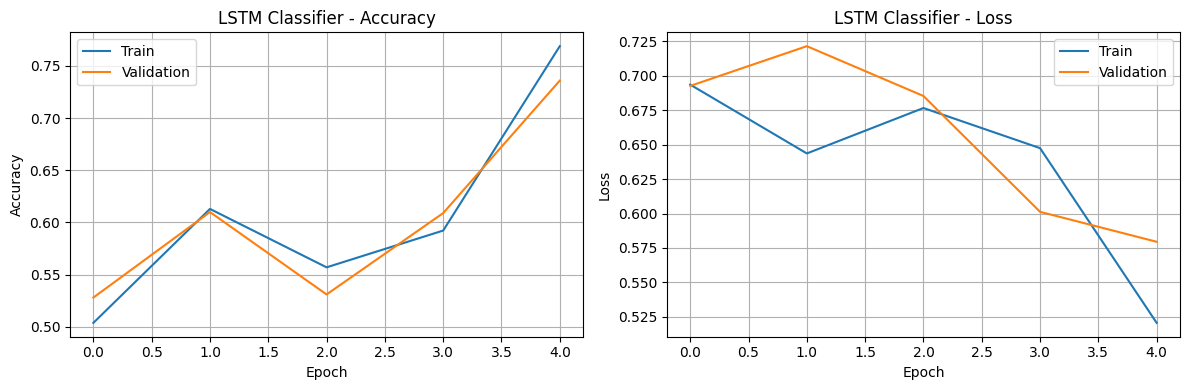

In [ ]:
plt.figure(figsize=(12, 4))

# Plot LSTM training history
plt.subplot(1, 2, 1)
plt.plot(history_lstm_classifier.history["accuracy"], label="Train")
plt.plot(history_lstm_classifier.history["val_accuracy"], label="Validation")
plt.title("LSTM Classifier - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_lstm_classifier.history["loss"], label="Train")
plt.plot(history_lstm_classifier.history["val_loss"], label="Validation")
plt.title("LSTM Classifier - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 4. Self-Check Questions

**RNNs and LSTMs**

1. What is the main difference between a simple RNN and an LSTM?
2. Why do RNNs struggle with long-range dependencies?
3. What are the roles of the forget, input, and output gates in an LSTM?
4. How does a bidirectional RNN differ from a standard RNN?

**Application Types**

5. What is the difference between an acceptor and a transducer architecture?
6. In what scenarios would you use an encoder-decoder model?
7. Why might you choose a bidirectional RNN for sentiment analysis?
8. What are the trade-offs between using LSTM and simple RNNs?



<!-- ## Summary

### Key Takeaways

#### RNN Architectures
1. **Acceptor**: Sequence → Single output (classification tasks)
2. **Transducer**: Sequence → Sequence, same length (tagging tasks)
3. **Encoder-Decoder**: Sequence → Sequence, different length (translation)
4. **Bidirectional**: Better context understanding with forward + backward processing



#### LSTM Advantages
- Gates control information flow (forget, input, output)
- Better at capturing long-range dependencies
- More stable gradients during training
- Generally outperforms simple RNNs on complex tasks

#### Practical Considerations
- LSTMs have more parameters → slower training, more data needed
- Simple RNNs can work well for shorter sequences
- Bidirectional models cannot be used for real-time prediction
- Modern alternatives: GRU (simpler), Transformers (attention-based) -->